In [1]:
import gym
import math
import numpy as np
from scipy.special import hyp2f1
from numpy.random import rand
from numpy.linalg import norm
from numpy import array
from numpy import zeros, zeros_like
from numpy import ones, ones_like
from numpy import inf
from numpy import minimum, maximum
import matplotlib.pyplot as plt
import os
from stable_baselines3.sac.policies import MlpPolicy
from stable_baselines3 import SAC
from stable_baselines3.common import results_plotter
from stable_baselines3.common.monitor import Monitor

Main modifications:

-Introduced guess mode
When in guess mode the environment is reset to a random state. When in normal mode the environment is reset to the best state so far.

-Agent trapped
Introduced a control that terminates the episode if the agent has taken too many steps without improvement.

-Min reward capped
When the rewards get smaller than a big multiple of the best reward the episode is terminated. This should avoid divergencies in the loss. 

-Action and initial state scaled
The action is scaled so that it can take value in [-6.5, 6.5], the initial random state is scaled so that it can take value in [0,6.5]


In [2]:
def g(h,hb,z,zb):
    return (1/2 if h==hb else 1)*(z**h*zb**hb*hyp2f1(h,h,2*h,z)*hyp2f1(hb,hb,2*hb,zb)+zb**h*z**hb*hyp2f1(h,h,2*h,zb)*hyp2f1(hb,hb,2*hb,z))

def p(h,hb,c,z,zb):
    return c*(((z-1)*(zb-1))**(1/8)*g(h,hb,z,zb)-z**(1/8)*zb**(1/8)*g(h,hb,1-z,1-zb))

pts = rand(29,2)


def e(spec,pts):
    return [(sum([p(n[0],n[1],n[2],z[0],z[1]) for n in spec]) + ((z[0]-1)*(z[1]-1))**(1/8)-z[0]**(1/8)*z[1]**(1/8)) for z in pts]

test_spec = array([[2.,2.,2.44e-4],[.5,.5,.25],[2.,0.,.016],[4.,0.,2.2e-4],[6.,0.,1.36e-5]])

spins = array([0,0,2,4,6])

class IsingEnv(gym.Env):
    def __init__(self, guess_mode_steps=0, trapped_steps=100, reward_cap=100, reward_scale=1.):
        self.action_space = gym.spaces.Box(array([-1 for i in range(10)]), array([1 for i in range(10)]))
        self.observation_space = gym.spaces.Box(array([-inf for i in range(29)]),array([inf for i in range(29)]))
        self.n = 5
        self.best_reward=None  #Records best reward
        self.best_state=None   #Records best state
        self.scale=reward_scale #Scale the error
        self.state = rand(10)*6.5 #Added in initialization
        self.guess_mode=True #Controls wheter the algorithm is working in guess mode
        self.guess_mode_steps=guess_mode_steps #Number of steps to take in guess mode
        self.step_counter=0 #Records the number of steps executed in the environment
        self.not_improving_steps=0 #Stores the number of steps since last improvement
        self.trapped_steps=trapped_steps #Maximum number of steps after which the environment is reset
        self.current_reward=None  #Current reward for guess mode
        self.improv_hist=[] #Records reward when a new best state is found

    def step(self, action):
        current_obs=self._get_obs()
        current_reward=-norm(current_obs)*self.scale
        self.state=self.state+action*6.5 #scale the action so it can reach all points in one step
        self.state = maximum(zeros_like(self.state), self.state)
        self.state = minimum(6.5*ones_like(self.state), self.state)
        obs = self._get_obs()
        reward = -norm(obs)*self.scale
         
        if self.best_reward is None:
            self.best_reward=reward
            self.best_state=self.state

        self.step_counter+=1 #Increase step counter to control guess_mode

        if self.guess_mode:

            if self.step_counter>self.guess_mode_steps: #end guess_mode
                self.guess_mode=False
                done=True
            #check update best reward
            if reward > self.best_reward:
                self.best_reward=reward
                self.best_state=self.state
                self.improv_hist.append((self.step_counter, reward, self.state))
                self.not_improving_steps=0


            if reward>current_reward:
                done=True
            else:
                self.not_improving_steps+=1
                done=False

        else:
            #check update best reward and terminate
            if reward > self.best_reward:
                self.best_reward=reward
                self.best_state=self.state
                self.not_improving_steps=0
                self.improv_hist.append((self.step_counter, reward, self.state))
                done = True
            else:
                self.not_improving_steps+=1
                done = False
            if reward<reward_cap*self.best_reward: #This should limit instabilities and divergencies
                    done=True

        if self.not_improving_steps>self.trapped_steps:
                self.not_improving_steps=0
                done=True

        info = {}
        return obs, reward, done, info

    def reset(self):
        if self.guess_mode:
            self.state = rand(10)*6.5 #reset to a random state only in guessing mode
        else:
            self.state=self.best_state
        return self._get_obs()

    def _get_obs(self):
        spec = [[(self.state[2*i]+spins[i])/2, (self.state[2*i]-spins[i])/2, self.state[2*i+1]]for i in range(self.n)]
        return e(spec, pts)

In [3]:
guess_steps=5000
total_steps=50000
trapped=20 
reward_scale=0.005

env=IsingEnv(guess_mode_steps=guess_steps,trapped_steps=trapped, reward_scale=0.005)
log_dir = "tmp/gym/"
os.makedirs(log_dir, exist_ok=True)
monitor=Monitor(env,log_dir)
model = SAC(MlpPolicy,monitor, verbose=1)
model.learn(total_timesteps=total_steps, log_interval=100)

C:\Users\Gabriele\.conda\envs\tf-gpu\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


Using cpu device
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 2.08      |
|    ep_rew_mean     | -4.44e+03 |
| time/              |           |
|    episodes        | 100       |
|    fps             | 21        |
|    time_elapsed    | 9         |
|    total timesteps | 208       |
| train/             |           |
|    actor_loss      | 1.7e+03   |
|    critic_loss     | 1.78e+07  |
|    ent_coef        | 1.03      |
|    ent_coef_loss   | -2.75     |
|    learning_rate   | 0.0003    |
|    n_updates       | 107       |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 2.4       |
|    ep_rew_mean     | -5.25e+03 |
| time/              |           |
|    episodes        | 200       |
|    fps             | 17        |
|    time_elapsed    | 26        |
|    total timesteps | 448       |
| train/             |           |
|  

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.26     |
|    ep_rew_mean     | -43.6    |
| time/              |          |
|    episodes        | 1500     |
|    fps             | 13       |
|    time_elapsed    | 445      |
|    total timesteps | 6039     |
| train/             |          |
|    actor_loss      | 4.46e+03 |
|    critic_loss     | 4.19e+06 |
|    ent_coef        | 5.79     |
|    ent_coef_loss   | -124     |
|    learning_rate   | 0.0003   |
|    n_updates       | 5938     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.22     |
|    ep_rew_mean     | -39.4    |
| time/              |          |
|    episodes        | 1600     |
|    fps             | 13       |
|    time_elapsed    | 456      |
|    total timesteps | 6161     |
| train/             |          |
|    actor_loss      | 3.94e+03 |
|    critic_loss     | 2.47e+06 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.43     |
|    ep_rew_mean     | -37.7    |
| time/              |          |
|    episodes        | 3000     |
|    fps             | 13       |
|    time_elapsed    | 614      |
|    total timesteps | 8055     |
| train/             |          |
|    actor_loss      | 5.09e+03 |
|    critic_loss     | 6.5e+06  |
|    ent_coef        | 9.6      |
|    ent_coef_loss   | -114     |
|    learning_rate   | 0.0003   |
|    n_updates       | 7954     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.35     |
|    ep_rew_mean     | -103     |
| time/              |          |
|    episodes        | 3100     |
|    fps             | 13       |
|    time_elapsed    | 626      |
|    total timesteps | 8190     |
| train/             |          |
|    actor_loss      | 5.77e+03 |
|    critic_loss     | 8.43e+06 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.41     |
|    ep_rew_mean     | -32.2    |
| time/              |          |
|    episodes        | 4500     |
|    fps             | 12       |
|    time_elapsed    | 796      |
|    total timesteps | 10189    |
| train/             |          |
|    actor_loss      | 6.62e+03 |
|    critic_loss     | 8.35e+06 |
|    ent_coef        | 16.3     |
|    ent_coef_loss   | -95      |
|    learning_rate   | 0.0003   |
|    n_updates       | 10088    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.48     |
|    ep_rew_mean     | -119     |
| time/              |          |
|    episodes        | 4600     |
|    fps             | 12       |
|    time_elapsed    | 809      |
|    total timesteps | 10337    |
| train/             |          |
|    actor_loss      | 6.79e+03 |
|    critic_loss     | 1.48e+07 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.55     |
|    ep_rew_mean     | -41.9    |
| time/              |          |
|    episodes        | 6000     |
|    fps             | 12       |
|    time_elapsed    | 982      |
|    total timesteps | 12380    |
| train/             |          |
|    actor_loss      | 9.17e+03 |
|    critic_loss     | 8.99e+06 |
|    ent_coef        | 28.5     |
|    ent_coef_loss   | -87.8    |
|    learning_rate   | 0.0003   |
|    n_updates       | 12279    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.48     |
|    ep_rew_mean     | -204     |
| time/              |          |
|    episodes        | 6100     |
|    fps             | 12       |
|    time_elapsed    | 994      |
|    total timesteps | 12528    |
| train/             |          |
|    actor_loss      | 9.32e+03 |
|    critic_loss     | 1.66e+07 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.25     |
|    ep_rew_mean     | -98.3    |
| time/              |          |
|    episodes        | 7500     |
|    fps             | 12       |
|    time_elapsed    | 1164     |
|    total timesteps | 14536    |
| train/             |          |
|    actor_loss      | 1.34e+04 |
|    critic_loss     | 4.42e+07 |
|    ent_coef        | 49.7     |
|    ent_coef_loss   | -95.9    |
|    learning_rate   | 0.0003   |
|    n_updates       | 14435    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.26     |
|    ep_rew_mean     | -197     |
| time/              |          |
|    episodes        | 7600     |
|    fps             | 12       |
|    time_elapsed    | 1175     |
|    total timesteps | 14662    |
| train/             |          |
|    actor_loss      | 1.37e+04 |
|    critic_loss     | 1.51e+07 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.26     |
|    ep_rew_mean     | -750     |
| time/              |          |
|    episodes        | 8900     |
|    fps             | 12       |
|    time_elapsed    | 1321     |
|    total timesteps | 16338    |
| train/             |          |
|    actor_loss      | 1.59e+04 |
|    critic_loss     | 1.32e+08 |
|    ent_coef        | 79.2     |
|    ent_coef_loss   | -55.1    |
|    learning_rate   | 0.0003   |
|    n_updates       | 16237    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.2      |
|    ep_rew_mean     | -974     |
| time/              |          |
|    episodes        | 9000     |
|    fps             | 12       |
|    time_elapsed    | 1331     |
|    total timesteps | 16458    |
| train/             |          |
|    actor_loss      | 1.57e+04 |
|    critic_loss     | 2.22e+07 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.18     |
|    ep_rew_mean     | -785     |
| time/              |          |
|    episodes        | 10300    |
|    fps             | 12       |
|    time_elapsed    | 1470     |
|    total timesteps | 18062    |
| train/             |          |
|    actor_loss      | 2.67e+04 |
|    critic_loss     | 2e+08    |
|    ent_coef        | 124      |
|    ent_coef_loss   | -91.8    |
|    learning_rate   | 0.0003   |
|    n_updates       | 17961    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.19     |
|    ep_rew_mean     | -787     |
| time/              |          |
|    episodes        | 10400    |
|    fps             | 12       |
|    time_elapsed    | 1481     |
|    total timesteps | 18181    |
| train/             |          |
|    actor_loss      | 2.45e+04 |
|    critic_loss     | 1.84e+08 |
|    ent_coef 

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 1.2       |
|    ep_rew_mean     | -1.13e+03 |
| time/              |           |
|    episodes        | 11700     |
|    fps             | 12        |
|    time_elapsed    | 1617      |
|    total timesteps | 19746     |
| train/             |           |
|    actor_loss      | 2.4e+04   |
|    critic_loss     | 3.09e+08  |
|    ent_coef        | 190       |
|    ent_coef_loss   | -46.3     |
|    learning_rate   | 0.0003    |
|    n_updates       | 19645     |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 1.21      |
|    ep_rew_mean     | -1.42e+03 |
| time/              |           |
|    episodes        | 11800     |
|    fps             | 12        |
|    time_elapsed    | 1628      |
|    total timesteps | 19867     |
| train/             |           |
|    actor_loss      | 2.62e+04  |
|    critic_loss    

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 1.21      |
|    ep_rew_mean     | -1.26e+03 |
| time/              |           |
|    episodes        | 13100     |
|    fps             | 12        |
|    time_elapsed    | 1763      |
|    total timesteps | 21414     |
| train/             |           |
|    actor_loss      | 3.42e+04  |
|    critic_loss     | 7.57e+08  |
|    ent_coef        | 286       |
|    ent_coef_loss   | -35.6     |
|    learning_rate   | 0.0003    |
|    n_updates       | 21313     |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 1.27      |
|    ep_rew_mean     | -1.66e+03 |
| time/              |           |
|    episodes        | 13200     |
|    fps             | 12        |
|    time_elapsed    | 1773      |
|    total timesteps | 21541     |
| train/             |           |
|    actor_loss      | 4.34e+04  |
|    critic_loss    

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 1.11      |
|    ep_rew_mean     | -1.98e+03 |
| time/              |           |
|    episodes        | 14500     |
|    fps             | 12        |
|    time_elapsed    | 1908      |
|    total timesteps | 23051     |
| train/             |           |
|    actor_loss      | 5.17e+04  |
|    critic_loss     | 4.48e+08  |
|    ent_coef        | 411       |
|    ent_coef_loss   | -29.2     |
|    learning_rate   | 0.0003    |
|    n_updates       | 22950     |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 1.19      |
|    ep_rew_mean     | -1.73e+03 |
| time/              |           |
|    episodes        | 14600     |
|    fps             | 12        |
|    time_elapsed    | 1918      |
|    total timesteps | 23170     |
| train/             |           |
|    actor_loss      | 4.07e+04  |
|    critic_loss    

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.3      |
|    ep_rew_mean     | -673     |
| time/              |          |
|    episodes        | 15900    |
|    fps             | 12       |
|    time_elapsed    | 2056     |
|    total timesteps | 24739    |
| train/             |          |
|    actor_loss      | 9.11e+03 |
|    critic_loss     | 8.39e+07 |
|    ent_coef        | 272      |
|    ent_coef_loss   | 64.2     |
|    learning_rate   | 0.0003   |
|    n_updates       | 24638    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.32     |
|    ep_rew_mean     | -825     |
| time/              |          |
|    episodes        | 16000    |
|    fps             | 12       |
|    time_elapsed    | 2068     |
|    total timesteps | 24871    |
| train/             |          |
|    actor_loss      | 3.03e+03 |
|    critic_loss     | 3.51e+07 |
|    ent_coef 

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 1.61      |
|    ep_rew_mean     | -285      |
| time/              |           |
|    episodes        | 17300     |
|    fps             | 12        |
|    time_elapsed    | 2223      |
|    total timesteps | 26711     |
| train/             |           |
|    actor_loss      | -9.31e+03 |
|    critic_loss     | 3.38e+07  |
|    ent_coef        | 148       |
|    ent_coef_loss   | 57.1      |
|    learning_rate   | 0.0003    |
|    n_updates       | 26610     |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 1.52      |
|    ep_rew_mean     | -176      |
| time/              |           |
|    episodes        | 17400     |
|    fps             | 12        |
|    time_elapsed    | 2235      |
|    total timesteps | 26863     |
| train/             |           |
|    actor_loss      | -9.38e+03 |
|    critic_loss    

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 3.15      |
|    ep_rew_mean     | -13.7     |
| time/              |           |
|    episodes        | 18700     |
|    fps             | 12        |
|    time_elapsed    | 2485      |
|    total timesteps | 29975     |
| train/             |           |
|    actor_loss      | -8.01e+03 |
|    critic_loss     | 3.73e+07  |
|    ent_coef        | 58        |
|    ent_coef_loss   | 34.6      |
|    learning_rate   | 0.0003    |
|    n_updates       | 29874     |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 3.87      |
|    ep_rew_mean     | -11.7     |
| time/              |           |
|    episodes        | 18800     |
|    fps             | 12        |
|    time_elapsed    | 2515      |
|    total timesteps | 30362     |
| train/             |           |
|    actor_loss      | -6.85e+03 |
|    critic_loss    

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.42     |
|    ep_rew_mean     | -2.39    |
| time/              |          |
|    episodes        | 20100    |
|    fps             | 12       |
|    time_elapsed    | 3738     |
|    total timesteps | 47264    |
| train/             |          |
|    actor_loss      | -274     |
|    critic_loss     | 9.5e+05  |
|    ent_coef        | 3.79     |
|    ent_coef_loss   | 0.356    |
|    learning_rate   | 0.0003   |
|    n_updates       | 47163    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.93     |
|    ep_rew_mean     | -5.99    |
| time/              |          |
|    episodes        | 20200    |
|    fps             | 12       |
|    time_elapsed    | 3754     |
|    total timesteps | 47457    |
| train/             |          |
|    actor_loss      | -316     |
|    critic_loss     | 1.12e+06 |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.59     |
|    ep_rew_mean     | -6.07    |
| time/              |          |
|    episodes        | 21600    |
|    fps             | 12       |
|    time_elapsed    | 3906     |
|    total timesteps | 49199    |
| train/             |          |
|    actor_loss      | -137     |
|    critic_loss     | 1.42e+06 |
|    ent_coef        | 3        |
|    ent_coef_loss   | 0.91     |
|    learning_rate   | 0.0003   |
|    n_updates       | 49098    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.16     |
|    ep_rew_mean     | -3.77    |
| time/              |          |
|    episodes        | 21700    |
|    fps             | 12       |
|    time_elapsed    | 3924     |
|    total timesteps | 49415    |
| train/             |          |
|    actor_loss      | -203     |
|    critic_loss     | 1.96e+06 |
|    ent_coef 

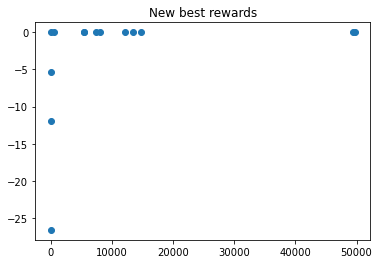

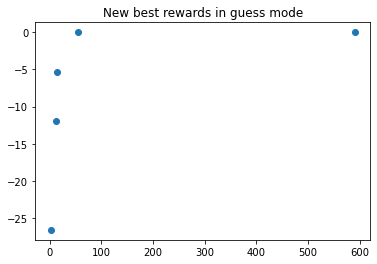

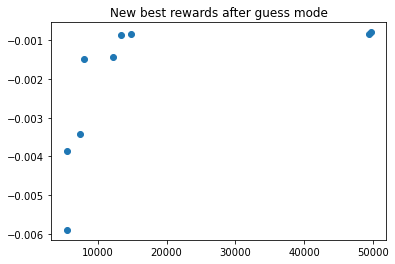

In [4]:
steps=[]
rew=[]
for el in env.improv_hist:
        steps.append(el[0])
        rew.append(el[1])
        
plt.scatter(steps,rew)
plt.title('New best rewards')
plt.show()

min_index=len(rew)
for i,step in enumerate(steps):
        if step>guess_steps:
                min_index=i
                break
                
plt.scatter(steps[:min_index],rew[:min_index])
plt.title('New best rewards in guess mode')
plt.show()
plt.scatter(steps[min_index:],rew[min_index:])
plt.title('New best rewards after guess mode')
plt.show()

Improvements in the later stages seem very sparse. 

In [5]:
print('Number of improvements:', len(rew))
print('Lowest error:', env.best_reward*(1/reward_scale))
print('Best state:', env.best_state)

Number of improvements: 14
Lowest error: -0.15842780755409658
Best state: [0.         0.         0.27759916 2.03850111 0.         0.
 6.5        0.         5.67327595 0.        ]


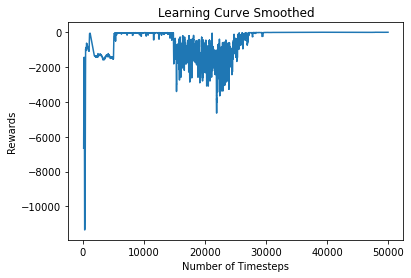

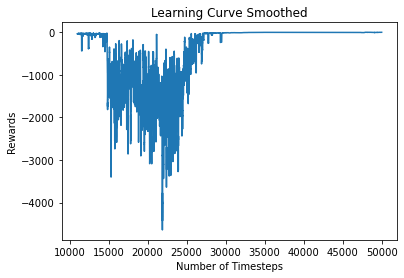

In [6]:
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')

def plot_results(log_folder, start=0, title='Learning Curve'):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = results_plotter.ts2xy(results_plotter.load_results(log_folder), 'timesteps')
    x=x[start:]
    y=y[start:]
    y = moving_average(y, window=50)
    # Truncate x
    x = x[len(x) - len(y):]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel('Number of Timesteps')
    plt.ylabel('Rewards')
    plt.title(title + " Smoothed")
    plt.show()
    
plot_results(log_dir)
plot_results(log_dir, start=guess_steps) #Plot only results after guess mode

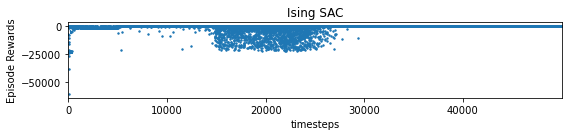

In [7]:
results_plotter.plot_results([log_dir], None, results_plotter.X_TIMESTEPS, "Ising SAC")
plt.show()